In [8]:
from analytical import *
from analytical import pc_profile as apc
from numerical import pc_profile as npc
from numerical import propag_deputy_and_analysis_col
from mubody.mission import Mission
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
from tqdm.auto import tqdm
import os
import utilities as utl
from astropy_healpix import HEALPix

%load_ext autoreload
%autoreload 2

%load_ext line_profiler
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Test performed in this notebook:

* Test of monte-carlo performance when N is increased. It should converge to analytical solution. To check this, the following results will be obtained:
    * Evolution of numerical results when N is increased. The higher N is, the closer the curves of different N should be
    * Evolution of analytical results when n is increased. The higher n is, the closer the curves of different n should be
    * Error between analytical and numerical results when N is increased. The analytical solution used as reference should have high n (n>5)

For all cases, the baseline configuration will be used.

# Test configuration

In [9]:
#if true, generates chief orbit
generate = False

#if true, saves figures
save = True

#if true saves data, else loads it
save_data = True


#time period
t0 = 0
tf = 86400

#nominal collision risk parameters
#distance between satellites [m]
d = 150

#safety sphere radius [m]
D = 50

#relation between sigmas
q = 0.2

#sigma of lateral velocity component [m/s]
sigma_vv = 0.001

#Number of cases for monte-carlo analysis
N = 100000
Na = 100

n = 3

#time resolution (time between distance check)
dT = 10

#vector with the mean value of the guassian distribution of each velocity component
mean_vector = np.array([0, 0, 0])

#Relative position
theta = 0
phi = 0

#comments
verbose = True

#type of probability
ptype = 'TP'


#path to store figures
figures_path = 'Results/test/figures/test_FETBP/'
file_path = 'test/data/test_FETBP'


In [10]:
mt = 180 * 86400
orbit_revolutions = mt/(180*86400)
model = 'FETBP'
frame = 'Sun-J2000Eq'
opt_iter = 3
chief_orbit_path = 'test/chief_orbit'
chief_orbit_name = 'chief_orbit_OTM_' + str(opt_iter) + '_' + str(np.round(orbit_revolutions,1)) + '_' + model

chief = Mission(mission_time=mt, primary_1='Sun', primary_2='Earth-Luna')
deputy = Mission(mission_time=tf, primary_1='Sun', primary_2='Earth-Luna')
if generate:
    chief.OTM(opt_iterations=opt_iter, bar=False, frame=frame, model=model)
    chief.save(chief_orbit_name, dir_name=chief_orbit_path)
else:
    try:
        chief.load(chief_orbit_name, chief_orbit_path)
    except:
        print("Orbit not found, generating one instead.")
        chief.OTM(opt_iterations=opt_iter, bar=False, frame=frame, model=model)
        chief.save(chief_orbit_name, dir_name=chief_orbit_path)


In [11]:
default_kwargs = {'t0': t0, 
        'tf' : tf,
        'd' : d, 
        'D' : D,
        'q' : q,
        'sigma_vv' : sigma_vv,
        'N' : N,
        'dT' : dT,
        'ptype' : ptype,
        'depRelVel' : mean_vector,
        'theta' : theta,
        'phi' : phi,
        'chief' : chief,
        'deputy' : deputy,
        'comt' : False,
        'Na' : Na,
        'n' : n,
        't0OrbChief' : 7510000*0,
        'model' : model,
        'frame' : frame
        }

if save_data:
        os.makedirs('Results/' + file_path, exist_ok=True)
        file = open('Results/' + file_path + "/test_conf.txt","w",)
 
        for key, value in default_kwargs.items():
        
                file.write('%s:%s\n' % (key, value))
        
        file.close()



In [12]:
def numeric_sweep(default_kwargs, parameter_name, parameter_list, tag):
    if save_data:
        kwargs = dict(default_kwargs)

        Nbar = len(parameter_list)
        pbar = tqdm(total=Nbar)

        results_sweep_list = []
        
        for p in parameter_list:
            results_sweep_dict = {}

            kwargs[parameter_name] = p

            x, y = npc(**kwargs)

            results_sweep_dict['time'] = x
            results_sweep_dict['TP'] = y[0]
            results_sweep_dict['IP'] = y[1]
            results_sweep_dict[parameter_name] = p
            
            results_sweep_list.append(results_sweep_dict)
            
            pbar.update(1)

        pbar.close()

        results_sweep_df = pd.DataFrame(data=results_sweep_list)

        utl.store(results_sweep_df, tag, file_path)
    else:
        results_sweep_df = utl.recover(tag, file_path)


    return results_sweep_df

def numeric_sweep_double(default_kwargs, parameter_name_1, parameter_list_1, parameter_name_2, parameter_list_2, tag):
    if save_data:
        kwargs = dict(default_kwargs)

        Nbar = len(parameter_list_1)
        pbar = tqdm(total=Nbar)

        results_sweep_list = []
        
        for idx, p in enumerate(parameter_list_1):
            results_sweep_dict = {}

            kwargs[parameter_name_1] = p
            kwargs[parameter_name_2] = parameter_list_2[idx]

            x, y = npc(**kwargs)

            results_sweep_dict['time'] = x
            results_sweep_dict['TP'] = y[0]
            results_sweep_dict['IP'] = y[1]
            results_sweep_dict[parameter_name_1] = p
            results_sweep_dict[parameter_name_2] = parameter_list_2[idx]
            
            results_sweep_list.append(results_sweep_dict)
            
            pbar.update(1)

        pbar.close()

        results_sweep_df = pd.DataFrame(data=results_sweep_list)

        utl.store(results_sweep_df, tag, file_path)
    else:
        results_sweep_df = utl.recover(tag, file_path)

    return results_sweep_df


def analytic_sweep(default_kwargs, parameter_name, parameter_list):

    kwargs = dict(default_kwargs)

    n = len(parameter_list)
    pbar = tqdm(total=n)

    results_sweep_list = []
    
    for p in parameter_list:
        results_sweep_dict = {}

        kwargs[parameter_name] = p

        kwargs['ptype'] = 'IP'
        x, y_ip = apc(**kwargs)
        results_sweep_dict['time'] = x
        results_sweep_dict['IP'] = y_ip

        kwargs['ptype'] = 'TP'
        x, y_tp = apc(**kwargs)
        results_sweep_dict['TP'] = y_tp

        results_sweep_dict[parameter_name] = p
        
        results_sweep_list.append(results_sweep_dict)

        pbar.update(1)

    pbar.close()

    results_sweep_df = pd.DataFrame(data=results_sweep_list)

    return results_sweep_df


def plot_df(df, parameter_name, result='IP', tag=None, save=False, legend_flag=True):
    index = df.index.values
    fig, ax = plt.subplots()
    legend = []

    for ids in index:
        xp = df.iloc[ids]['time']
        yp = df.iloc[ids][result]
        ax.plot(xp, yp)
        legend.append(parameter_name + '=' + str(df.iloc[ids][parameter_name]))
        
    if legend_flag: ax.legend(legend)

    ax.set_title(str(result) + " variation over " + str(parameter_name))

    if save:
        os.makedirs(figures_path, exist_ok=True)
        if tag==None: tag = parameter_name
        fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')


    return fig, ax


In [13]:
parameter_name = 'N'
parameter_list = [1000, 2500, 5000]

low_N_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='low_N_nsweep')

100%|██████████| 3/3 [02:46<00:00, 55.58s/it]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TP variation over N'}>)

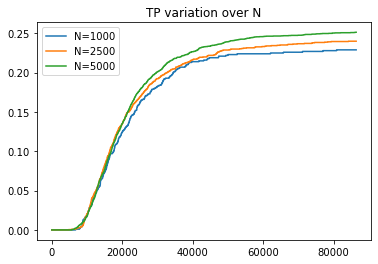

In [14]:
plot_df(low_N_nsweep_df, 'N', result='IP', tag='low_N_nsweep_IP', save=True)
plot_df(low_N_nsweep_df, 'N', result='TP', tag='low_N_nsweep_TP', save=True)

In [15]:
parameter_name = 'N'
parameter_list = [5000, 10000, 50000, 100000]

high_N_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='high_N_nsweep')

100%|██████████| 4/4 [53:46<00:00, 806.55s/it] 


In [16]:
plot_df(high_N_nsweep_df, 'N', result='IP', tag='high_N_nsweep_IP', save=True)
plot_df(high_N_nsweep_df, 'N', result='TP', tag='high_N_nsweep_TP', save=True)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TP variation over N'}>)

In [17]:
parameter_name = 'n'
parameter_list = [3, 4, 5, 6]

n_asweep_df = analytic_sweep(default_kwargs, parameter_name, parameter_list)

100%|██████████| 4/4 [07:11<00:00, 107.78s/it]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TP variation over n'}>)

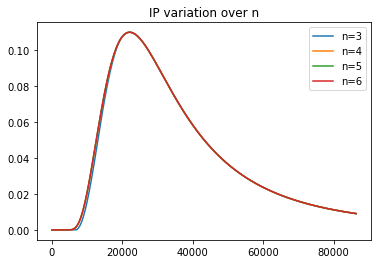

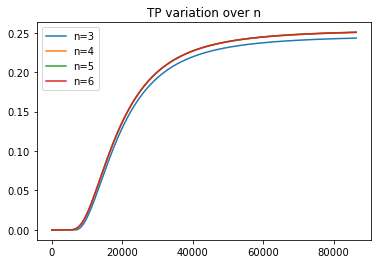

In [18]:
plot_df(n_asweep_df, 'n', result='IP', tag='n_asweep_IP', save=True)
plot_df(n_asweep_df, 'n', result='TP', tag='n_asweep_TP', save=True)

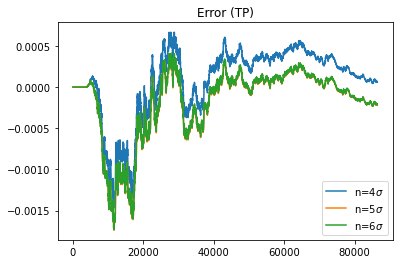

In [19]:
fig, ax = plt.subplots()
tag = "TP_error_global"
result = 'TP'

x = n_asweep_df.iloc[0]['time']
yn = high_N_nsweep_df.iloc[-1][result]

legend = []

for i in range(4):
    ya = n_asweep_df.iloc[i][result]
    error = (yn - ya)
    ax.plot(x, error)
    legend.append('n' + '=' + str(n_asweep_df.iloc[i]['n'])+ '$\sigma$')

ax.legend(legend)
ax.set_title("Error (TP)")
fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')


fig, ax = plt.subplots()
tag = "TP_error_detail"
x = n_asweep_df.iloc[0]['time']
yn = high_N_nsweep_df.iloc[-1][result]

legend = []

ids = 1
for i in range(4-ids):
    ya = n_asweep_df.iloc[i+ids][result]
    error = (yn - ya)
    ax.plot(x, error)
    legend.append('n' + '=' + str(n_asweep_df.iloc[i+ids]['n'])+ '$\sigma$')

ax.legend(legend)
ax.set_title("Error (TP)")
fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')

In [20]:
fig, ax = plt.subplots()
tag = "IP_error_global"
result = 'IP'

x = n_asweep_df.iloc[0]['time']
yn = high_N_nsweep_df.iloc[-1][result]

legend = []

for i in range(4):
    ya = n_asweep_df.iloc[i][result]
    error = (yn - ya)
    ax.plot(x, error)
    legend.append('n' + '=' + str(n_asweep_df.iloc[i]['n'])+ '$\sigma$')

ax.legend(legend)
ax.set_title("Error (IP)")
fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')


fig, ax = plt.subplots()
tag = "IP_error_detail"

x = n_asweep_df.iloc[0]['time']
yn = high_N_nsweep_df.iloc[-1][result]

legend = []

ids = 1
for i in range(4-ids):
    ya = n_asweep_df.iloc[i+ids][result]
    error = (yn - ya)
    ax.plot(x, error)
    legend.append('n' + '=' + str(n_asweep_df.iloc[i+ids]['n'])+ '$\sigma$')

ax.legend(legend)
ax.set_title("Error (IP)")
fig.savefig(figures_path + tag + '.jpg', dpi=300, format='jpg')

## About the relative error:

Although the relative error is mostly around 2%-3% (ids=600), there is a region, just where the collision risk starts to rise, when it reaches a considerable magnitude. However, absolute error and the relative error referred to the maximum value of probability are both quite low. This happens because in this region the probilitity of collision is very low and the error associated to the collision risk is high in comparison.

In [21]:
error_r = np.zeros_like(ya)
error_r_max = np.zeros_like(ya)

for i in range(len(ya)):
    if ya[i]==0:
        error_r[i] = np.nan
        error_r_max[i] = np.nan
    else:
        error_r[i] = 100*abs(yn[i] - ya[i])/ya[i]
        error_r_max[i] = 100*abs(yn[i] - ya[i])/ya.max()


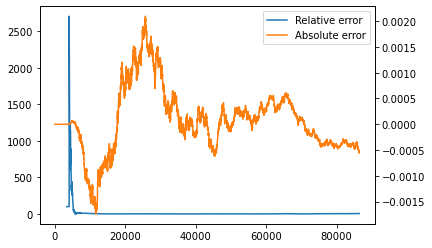

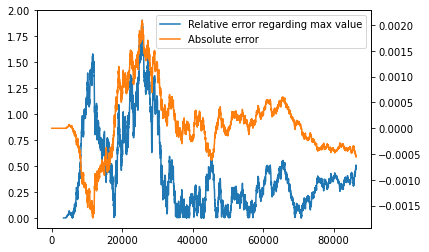

In [22]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ids = 0
ide = -1
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x[ids:ide], error_r[ids:ide], colors[0], label='Relative error')
ax2.plot(x[ids:ide], (yn-ya)[ids:ide], colors[1], label='Absolute error')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x[ids:ide], error_r[ids:ide], colors[0], label='Relative error')
ax2.plot(x[ids:ide], error_r_max[ids:ide], colors[1], label='Relative error regarding max value')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x[ids:ide], error_r_max[ids:ide], colors[0], label='Relative error regarding max value')
ax2.plot(x[ids:ide], (yn-ya)[ids:ide], colors[1], label='Absolute error')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)


In [23]:
parameter_name = 'phi'
parameter_list = np.linspace(-90,90, 5)

phi_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='phi_nsweep')

100%|██████████| 5/5 [2:43:22<00:00, 1960.47s/it]  


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TP variation over phi'}>)

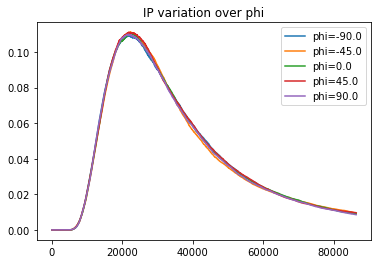

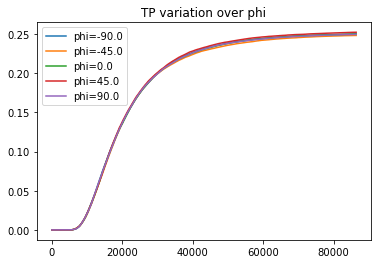

In [24]:
plot_df(phi_nsweep_df, 'phi', result='IP', tag='phi_nsweep_IP', save=True)
plot_df(phi_nsweep_df, 'phi', result='TP', tag='phi_nsweep_TP', save=True)

In [25]:
parameter_name = 'theta'
parameter_list = np.linspace(-180,180, 10)

theta_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='theta_nsweep')

100%|██████████| 10/10 [5:26:58<00:00, 1961.85s/it] 


In [26]:
plot_df(theta_nsweep_df, 'theta', result='IP', tag='theta_nsweep_IP', save=True)
plot_df(theta_nsweep_df, 'theta', result='TP', tag='theta_nsweep_TP', save=True)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TP variation over theta'}>)

In [27]:
hp = HEALPix(nside=1)
p = np.arange(0, hp.npix)

hp.healpix_to_lonlat(p)[0].value

array([0.78539816, 2.35619449, 3.92699082, 5.49778714, 0.        ,
       1.57079633, 3.14159265, 4.71238898, 0.78539816, 2.35619449,
       3.92699082, 5.49778714])

In [28]:

phi_list = hp.healpix_to_lonlat(p)[0].value

theta_list = hp.healpix_to_lonlat(p)[1].value

phi_theta_nsweep_df = numeric_sweep_double(default_kwargs, 'phi', theta_list, 'theta', phi_list, tag='phi_theta_nsweep')

100%|██████████| 12/12 [6:32:13<00:00, 1961.11s/it]  


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TP variation over phi'}>)

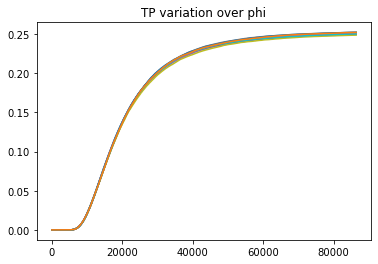

In [29]:
plot_df(phi_theta_nsweep_df, 'phi', result='IP', tag='phi_theta_nsweep_IP', save=True, legend_flag=False)
plot_df(phi_theta_nsweep_df, 'phi', result='TP', tag='phi_theta_nsweep_TP', save=True, legend_flag=False)

## Variation over position in orbit

In [30]:
# parameter_name = 't_chief_orbit_position_s'
# parameter_list = np.linspace(86400,170*86400, 8)

# OrbitPosition_nsweep_df = numeric_sweep(default_kwargs, parameter_name, parameter_list, tag='orbitPosition_nsweep')

In [31]:
# plot_df(OrbitPosition_nsweep_df, 't_chief_orbit_position_s', result='TP', tag='orbitPosition_nsweep_TP', save=True, legend_flag=False)
# plot_df(OrbitPosition_nsweep_df, 't_chief_orbit_position_s', result='IP', tag='orbitPosition_nsweep_IP', save=True, legend_flag=False)